In [32]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
faturamento_df = pd.read_csv("data/faturamento_lojas_atuais.csv")
lojas_df = pd.read_csv("data/lojas_atuais.csv")

### Tratamento dos dados

In [72]:
faturamento_df["datetime"] = pd.to_datetime(faturamento_df.ano*100 + faturamento_df.mes, format='%Y%m')
fat_df = faturamento_df.groupby(["cod_loja", "datetime"] , as_index=False).sum()
fat_df.drop(["ano", "mes", "qtde"], axis=1, inplace=True)

df = fat_df.merge(lojas_df, left_on="cod_loja", right_on="cod_loja")
df["quarter"] = df["datetime"].dt.quarter
df["ano"] = df["datetime"].dt.year
df["mes"] = df["datetime"].dt.month
df["feature_03"] = df["feature_03"].apply(lambda x: 1 if x else 0)

In [76]:
print(df.shape)
df.head()

(73644, 26)


,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,quarter,ano,mes
0,1,2016-01-01,441833.37,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,1
1,1,2016-02-01,395340.22,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,2
2,1,2016-03-01,587810.18,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,3
3,1,2016-04-01,534618.84,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2016,4
4,1,2016-05-01,595477.92,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2016,5


In [77]:
def categoriza_lojas(row):
    if row["receita"] <= 75000:
        return 0
    elif row["receita"] <= 2e5:
        return 10
    elif row["receita"] <= 4e5:
        return 20
    elif row["receita"] <= 6e5:
        return 30
    else:
        return 40
    
def obtem_categoria(cod_loja):
    return categorias_df[categorias_df["cod_loja"] == cod_loja]["categoria_loja"].values[0]


categorias_df = df.groupby(["cod_loja"], as_index=False).mean()[["cod_loja", "receita"]]
categorias_df["categoria_loja"] = categorias_df.apply(categoriza_lojas, axis=1)

df["categoria_loja"] = df["cod_loja"].apply(obtem_categoria)

In [78]:
df.head()

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,quarter,ano,mes,categoria_loja
0,1,2016-01-01,441833.37,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,1,40
1,1,2016-02-01,395340.22,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,2,40
2,1,2016-03-01,587810.18,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,3,40
3,1,2016-04-01,534618.84,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2016,4,40
4,1,2016-05-01,595477.92,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2016,5,40


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73644 entries, 0 to 73643
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cod_loja        73644 non-null  int64         
 1   datetime        73644 non-null  datetime64[ns]
 2   receita         73644 non-null  float64       
 3   cod_ap          73644 non-null  int64         
 4   cod_municipio   73644 non-null  int64         
 5   feature_01      26972 non-null  object        
 6   feature_02      73644 non-null  object        
 7   feature_03      73644 non-null  int64         
 8   feature_04      73644 non-null  float64       
 9   feature_05      73644 non-null  object        
 10  feature_06      73644 non-null  int64         
 11  feature_07      73644 non-null  float64       
 12  feature_08      73644 non-null  float64       
 13  feature_09      73644 non-null  float64       
 14  feature_10      73644 non-null  float64       
 15  fe

In [80]:
has_na_cols = list()
for col in df.columns:
    if df[col].isnull().values.any():
        has_na_cols.append(col)
has_na_cols

['feature_01',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18']

In [81]:
for na_col in has_na_cols:
    if df[na_col].dtype == object:
        print(df[na_col].mode()[0])
        df[na_col].fillna(df[na_col].mode()[0], inplace=True)
    else:
        df[na_col].fillna(df[na_col].median(), inplace=True)

FEATURE_01_VALUE_10
FEATURE_11_VALUE_02
FEATURE_12_VALUE_01


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73644 entries, 0 to 73643
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cod_loja        73644 non-null  int64         
 1   datetime        73644 non-null  datetime64[ns]
 2   receita         73644 non-null  float64       
 3   cod_ap          73644 non-null  int64         
 4   cod_municipio   73644 non-null  int64         
 5   feature_01      73644 non-null  object        
 6   feature_02      73644 non-null  object        
 7   feature_03      73644 non-null  int64         
 8   feature_04      73644 non-null  float64       
 9   feature_05      73644 non-null  object        
 10  feature_06      73644 non-null  int64         
 11  feature_07      73644 non-null  float64       
 12  feature_08      73644 non-null  float64       
 13  feature_09      73644 non-null  float64       
 14  feature_10      73644 non-null  float64       
 15  fe

## Adicionar a receita do ultimo trimestre

In [83]:
df.head()

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,quarter,ano,mes,categoria_loja
0,1,2016-01-01,441833.37,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,1,2016,1,40
1,1,2016-02-01,395340.22,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,1,2016,2,40
2,1,2016-03-01,587810.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,1,2016,3,40
3,1,2016-04-01,534618.84,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,2,2016,4,40
4,1,2016-05-01,595477.92,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,2,2016,5,40


In [84]:
df.shape

(73644, 27)

In [85]:
receita_ultimo_trimestre = []

for index, row in df.iterrows():
    if row["ano"] == 2016 and row["quarter"] == 1:
        receita_ultimo_trimestre.append([index, 0,0,0,0])
    # Há semestre anterior
    else:
        #ultimo trimestre do ano passado
        quarter = row["quarter"] - 1
        ano = row["ano"]
        
        if quarter == 0:
            ano = row["ano"]-1
            quarter = 4
            
        last_quarter_df = df[(df["cod_loja"] == row["cod_loja"]) & (df["quarter"] == quarter) & (df["ano"] == ano)] \
                          .sort_values("datetime")[["datetime", "receita"]]
        receita = last_quarter_df["receita"].values
        if len(receita) == 3:
            receita_ultimo_trimestre.append([index, receita[0], receita[1], receita[2], np.mean(receita)])
        else:
            ## rever
            receita_ultimo_trimestre.append([index, 0, 0, 0, 0])
            
    
receita_ultimo_trimestre_df = pd.DataFrame(receita_ultimo_trimestre, columns=["index", "receita_trim1", "receita_trim2", "receita_trim3", "receita_media"]).set_index("index")
receita_ultimo_trimestre_df.head()
df = df.merge(receita_ultimo_trimestre_df, left_index=True, right_index=True)

In [86]:
df.shape

(73644, 31)

In [87]:
## receita no mesmo mês do ana passado
receita_ano_passado = []

for index, row in df.iterrows():
    year_ago = row["datetime"].replace(year=row["ano"]-1)
    
    year_agora_df = df[(df["cod_loja"] == row["cod_loja"]) & (df["datetime"] == year_ago)]
    
    if year_agora_df.shape[0] == 1:
        receita_ano_passado.append([index, year_agora_df["receita"].values[0]])
    else:
        receita_ano_passado.append([index, 0])
        
receita_ultimo_ano_df = pd.DataFrame(receita_ano_passado, columns=["index", "receita_ano_passado"]).set_index("index")
receita_ultimo_ano_df.head()
df = df.merge(receita_ultimo_ano_df, left_index=True, right_index=True)
df.shape

(73644, 32)

In [88]:
df.shape

(73644, 32)

In [89]:
df.to_csv('data/faturamento_consolidade_sem_feriado.csv', index=False)

In [95]:
df[df["cod_loja"] == 1]

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_18,quarter,ano,mes,categoria_loja,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado
0,1,2016-01-01,441833.37,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,1,2016,1,40,0.00,0.00,0.00,0.000000,0.00
1,1,2016-02-01,395340.22,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,1,2016,2,40,0.00,0.00,0.00,0.000000,0.00
2,1,2016-03-01,587810.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,1,2016,3,40,0.00,0.00,0.00,0.000000,0.00
3,1,2016-04-01,534618.84,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,2,2016,4,40,441833.37,395340.22,587810.18,474994.590000,0.00
4,1,2016-05-01,595477.92,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,2,2016,5,40,441833.37,395340.22,587810.18,474994.590000,0.00
5,1,2016-06-01,589947.05,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,2,2016,6,40,441833.37,395340.22,587810.18,474994.590000,0.00
6,1,2016-07-01,563814.03,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,3,2016,7,40,534618.84,595477.92,589947.05,573347.936667,0.00
7,1,2016-08-01,625181.36,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,3,2016,8,40,534618.84,595477.92,589947.05,573347.936667,0.00
8,1,2016-09-01,583509.12,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,3,2016,9,40,534618.84,595477.92,589947.05,573347.936667,0.00
9,1,2016-10-01,611797.30,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,90.5,4,2016,10,40,563814.03,625181.36,583509.12,590834.836667,0.00


In [91]:
feriados_df = pd.read_csv("data/feriados.csv")
com_feriados_df = df.merge(feriados_df, left_on=['cod_loja', 'mes'], right_on=['cod_loja', 'mes'], how='left')
com_feriados_df = com_feriados_df.drop(columns=['mes', 'Unnamed: 0'])

In [105]:
feriados_df[feriados_df["cod_loja"] == 1].head(50)

,Unnamed: 0,cod_loja,mes,cnt_feriados
0,0,1,1,1.0
1,1,1,2,0.0
2,2,1,3,0.0
3,3,1,4,1.0
4,4,1,5,1.0
5,5,1,6,0.0
6,6,1,7,0.0
7,7,1,8,0.0
8,8,1,9,1.0
9,9,1,10,1.0


In [24]:
# str_cols = list()
# for col in df.columns.values.tolist():
#     if df[col].dtype == object:
#         str_cols.append(col)
        
# str_cols
dummies_df = pd.get_dummies(df, columns=["feature_05", "feature_01", "feature_02", "feature_11", "feature_12"])
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995371 entries, 0 to 1995370
Data columns (total 52 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   cod_loja                        int64         
 1   datetime                        datetime64[ns]
 2   receita                         float64       
 3   cod_ap                          int64         
 4   cod_municipio                   int64         
 5   feature_03                      int64         
 6   feature_04                      float64       
 7   feature_06                      int64         
 8   feature_07                      float64       
 9   feature_08                      float64       
 10  feature_09                      float64       
 11  feature_10                      float64       
 12  feature_13                      float64       
 13  feature_14                      float64       
 14  feature_15                      float64       
 15

In [25]:
train_df = dummies_df[~dummies_df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]
test_df =  dummies_df[dummies_df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]

In [26]:
str_cols = []        
str_cols.append("datetime")
str_cols.append("receita")
str_cols.append("receita_trim1")
str_cols.append("receita_trim2")
str_cols.append("receita_trim3")

X_train = train_df.drop(str_cols, axis=1, errors="ignore")
y_train = train_df["receita"]

X_test = test_df.drop(str_cols, axis=1, errors="ignore")
y_test = test_df["receita"]

In [27]:
X_test.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'quarter', 'ano', 'categoria_loja', 'receita_media',
       'receita_ano_passado', 'feature_05_FEATURE_05_VALUE_01',
       'feature_05_FEATURE_05_VALUE_02', 'feature_05_FEATURE_05_VALUE_03',
       'feature_05_FEATURE_05_VALUE_04', 'feature_05_FEATURE_05_VALUE_05',
       'feature_05_FEATURE_05_VALUE_06', 'feature_05_FEATURE_05_VALUE_07',
       'feature_05_FEATURE_05_VALUE_08', 'cnt_feriados',
       'feature_01_FEATURE_01_VALUE_03', 'feature_01_FEATURE_01_VALUE_06',
       'feature_01_FEATURE_01_VALUE_08', 'feature_01_FEATURE_01_VALUE_10',
       'feature_02_FEATURE_02_VALUE_02', 'feature_02_FEATURE_02_VALUE_03',
       'feature_02_FEATURE_02_VALUE_04', 'feature_02_FEATURE_02_VALUE_06',
       'feature_11_FEATURE_11_VALUE_01', 'feature_11

In [28]:
X_train.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'quarter', 'ano', 'categoria_loja', 'receita_media',
       'receita_ano_passado', 'feature_05_FEATURE_05_VALUE_01',
       'feature_05_FEATURE_05_VALUE_02', 'feature_05_FEATURE_05_VALUE_03',
       'feature_05_FEATURE_05_VALUE_04', 'feature_05_FEATURE_05_VALUE_05',
       'feature_05_FEATURE_05_VALUE_06', 'feature_05_FEATURE_05_VALUE_07',
       'feature_05_FEATURE_05_VALUE_08', 'cnt_feriados',
       'feature_01_FEATURE_01_VALUE_03', 'feature_01_FEATURE_01_VALUE_06',
       'feature_01_FEATURE_01_VALUE_08', 'feature_01_FEATURE_01_VALUE_10',
       'feature_02_FEATURE_02_VALUE_02', 'feature_02_FEATURE_02_VALUE_03',
       'feature_02_FEATURE_02_VALUE_04', 'feature_02_FEATURE_02_VALUE_06',
       'feature_11_FEATURE_11_VALUE_01', 'feature_11

### Treinar o modelo

In [31]:
rf = RandomForestRegressor(n_estimators=500, n_jobs=8, verbose=2)
rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [18]:
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train) 
np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))

(7587.304948612435, 30251.9991313889)

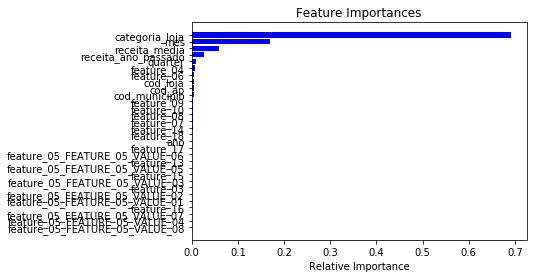

In [19]:
def print_feature_importances(model, cols):
    features = cols
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(16,9))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance');
    
print_feature_importances(rf, X_train.columns)  

In [20]:

feriados_df.head()

,Unnamed: 0,cod_loja,mes,cnt_feriados
0,0,1,1,1.0
1,1,1,2,0.0
2,2,1,3,0.0
3,3,1,4,1.0
4,4,1,5,1.0
